<a href="https://colab.research.google.com/github/marcocaramanti/MLPNS_MCaramanti/blob/main/convolutional_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [4]:
plt.rcParams["figure.figsize"] = [10, 8]
plt.rcParams["image.interpolation"] = "nearest"
# Cioè niente interpolazione fra i pixel dell'immagine
plt.rcParams["image.cmap"] = "gist_gray"

In [5]:
cd /content/drive/MyDrive/MLPNS2023

/content/drive/MyDrive/MLPNS2023


In [6]:
ls

higgsBoson/     spm-20210427T111354Z-001.zip  wine.names
kaggleTitanic/  wine.data


In [7]:
!unzip spm-20210427T111354Z-001.zip

Archive:  spm-20210427T111354Z-001.zip
  inflating: spm/spm_struct_pos.npy  
  inflating: spm/spm_struct_neg.npy  
  inflating: spm/test_good_all.npy   
  inflating: spm/train_good_all.npy  
  inflating: spm/test_bad_all.npy    
  inflating: spm/train_bad_all.npy   


In [8]:
# I dati da leggere sono tutti numpy array. Sono salvati in formato binario
# sfruttando il pacchetto pickle

data = np.load("spm/train_good_all.npy")
# Usiamo questo sia come trainset sia testset: splitteremo con l'apposita
# funzione

In [9]:
data.shape

(1302, 64, 64)

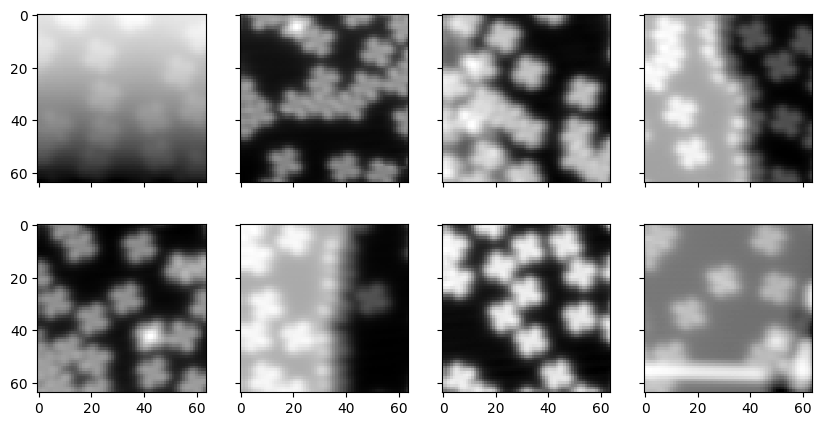

In [10]:
# Sono 1302 immagini, ciascuna 64x64
# Plottiamo le prime otto

fig, ax = plt.subplots(2, 4, figsize=[10,5], sharex=True, sharey=True)
for ii in range(8):
  ax[ii // 4, ii % 4].imshow(data[ii])

La nostra NN servirà per identificare la posizione di oggetti nelle immagini. L'oggetto saranno queste molecole a croce. Per farlo servono esempi per sapere dove sono le molecole e dove non sono. Creeremo convolutional NN per farlo. Una CNN impara le weight map, cioè le forme con cui fare la convoluzione.

(array([ 254226.,  957465., 1143646., 1050540.,  825288.,  338534.,
         391059.,  151471.,  179803.,   40960.]),
 array([-1.07775726e-07, -9.55749615e-08, -8.33741970e-08, -7.11734324e-08,
        -5.89726678e-08, -4.67719032e-08, -3.45711387e-08, -2.23703741e-08,
        -1.01696095e-08,  2.03115507e-09,  1.42319196e-08]),
 <BarContainer object of 10 artists>)

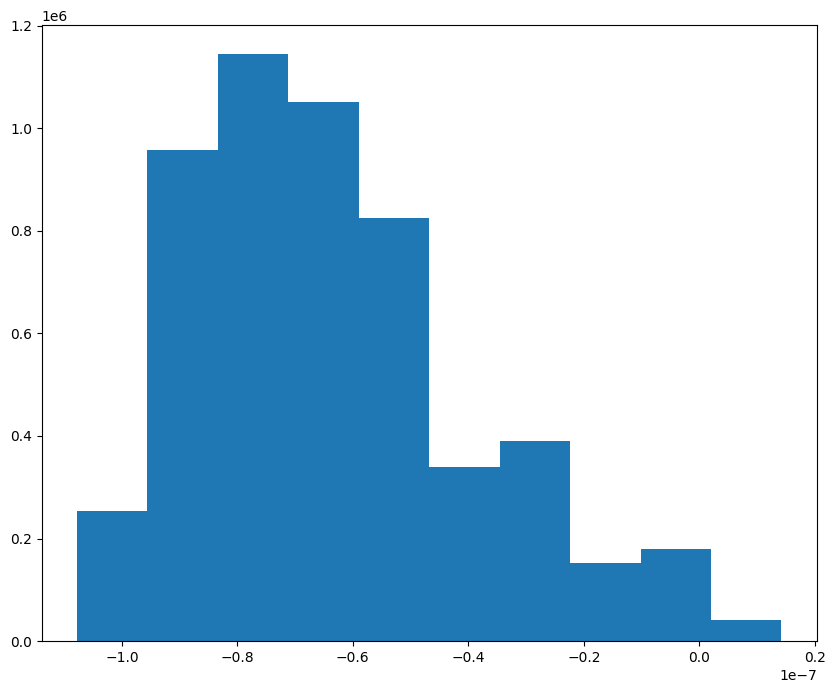

In [14]:
# Per capire il range dei dati estraiamo tutti i pixel e facciamo un istogramma

plt.hist(data.flatten())

Il range va a $10^{-7}$. Range non buono: può dare problemi numerici. Solitamente allora si fa uno scaling e portare tutto fra 0 e 1.

$$
\frac{D - \min{D}}{\text{range}(D)}
$$

In [11]:
norm = (data - data.min(axis=(1,2), keepdims=True))/(
    data.max(axis=(1,2), keepdims=True) - data.min(axis=(1,2), keepdims=True))

In [12]:
norm.shape

(1302, 64, 64)

In [13]:
norm.min(), norm.max()

(0.0, 1.0)

In [16]:
pos = np.load("spm/spm_struct_pos.npy")
neg = np.load("spm/spm_struct_neg.npy")

In [17]:
pos.shape, neg.shape

((500, 3), (500, 3))

In [18]:
pos[0]

array([30, 25, 51])

In [19]:
pos.max(axis=0)
# Il numero dell'immagine è il terzo numero, i primi due sono la posizione

array([  62,   62, 1300])

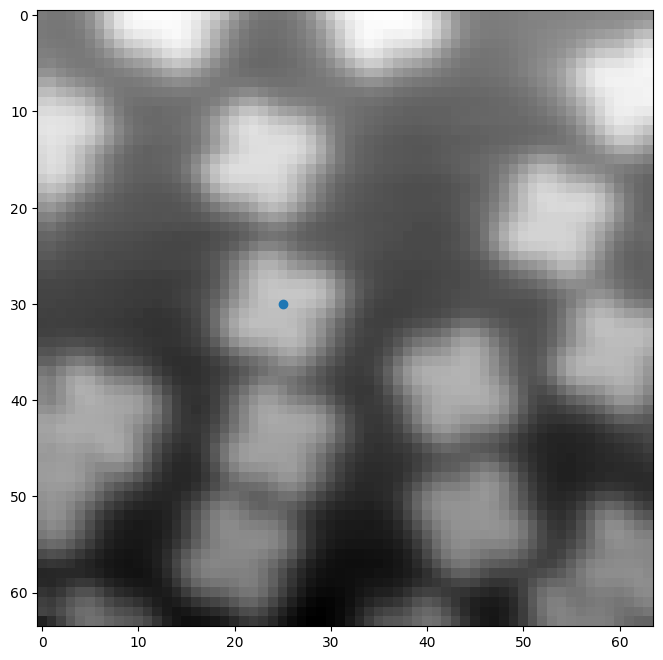

In [24]:
plt.imshow(norm[pos[0][2]])
plt.plot(pos[0][1], pos[0][0], 'o')

In [28]:
# Creiamo i postage stamp

wid = 10
stmp_pos = []

for ii in range(pos.shape[0]):
  trow, tcol, tind = pos[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_pos.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])

stmp_pos = np.array(stmp_pos)

In [29]:
stmp_pos.shape

(389, 20, 20)

In [30]:
pos.shape[0]

500

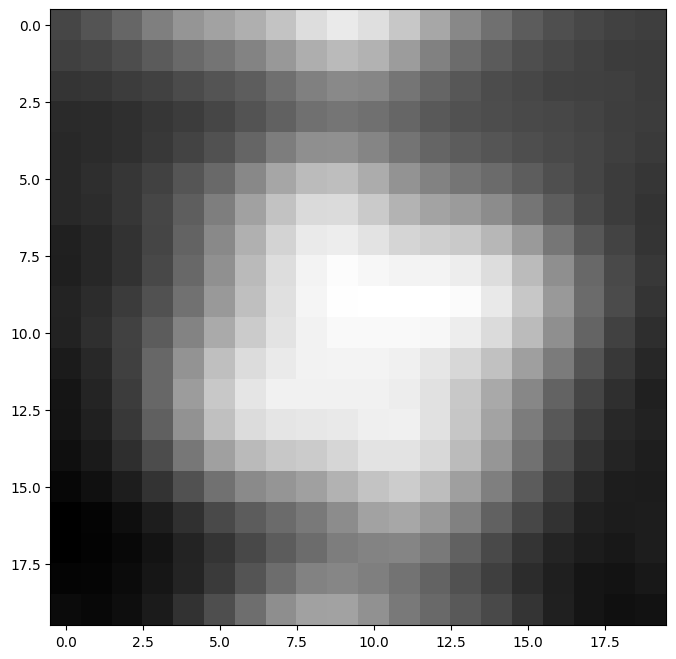

In [31]:
plt.imshow(stmp_pos[0])

In [32]:
wid = 10
stmp_neg = []

for ii in range(pos.shape[0]):
  trow, tcol, tind = neg[ii]
  if (trow > wid) & (trow < 64 - wid) & (tcol > wid) & (tcol < 64 - wid):
    stmp_neg.append(norm[tind, trow-wid:trow+wid, tcol-wid:tcol+wid])

stmp_neg = np.array(stmp_neg)

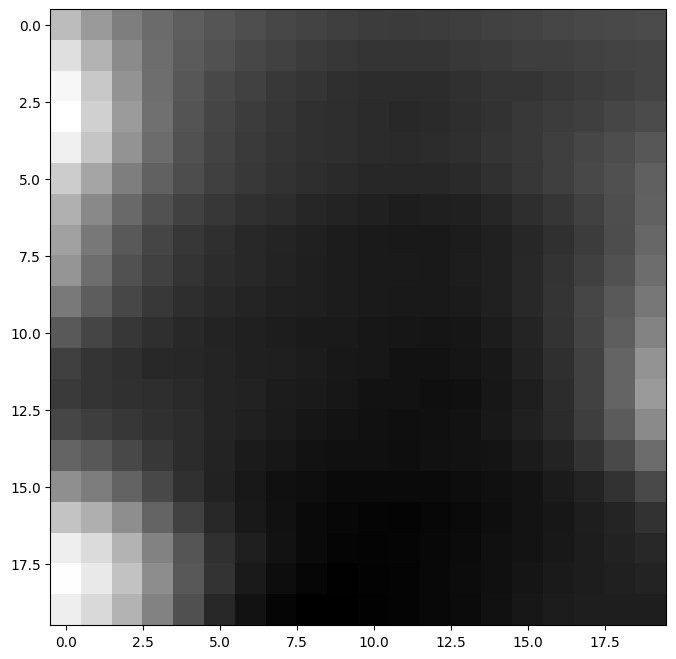

In [34]:
plt.imshow(stmp_neg[0])

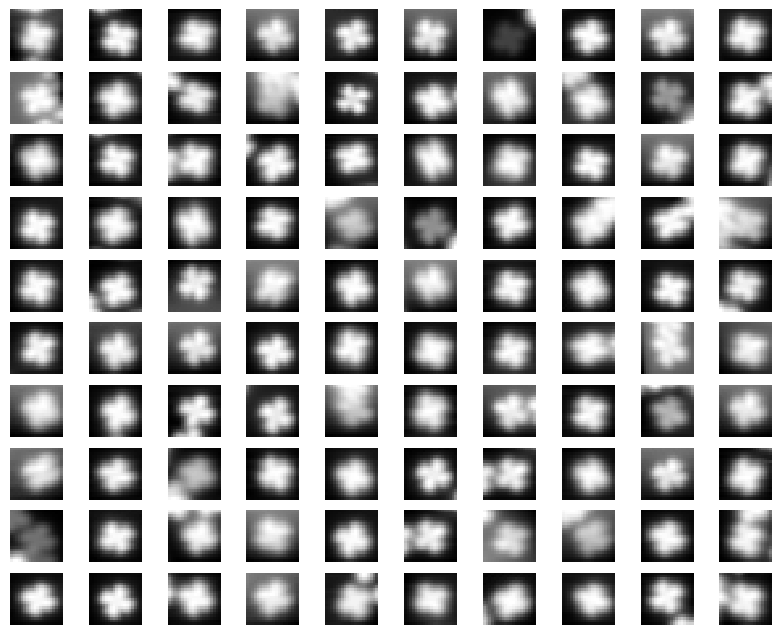

In [35]:
# plot  positive examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_pos[ii])
    ax[ii // 10, ii % 10].axis("off")

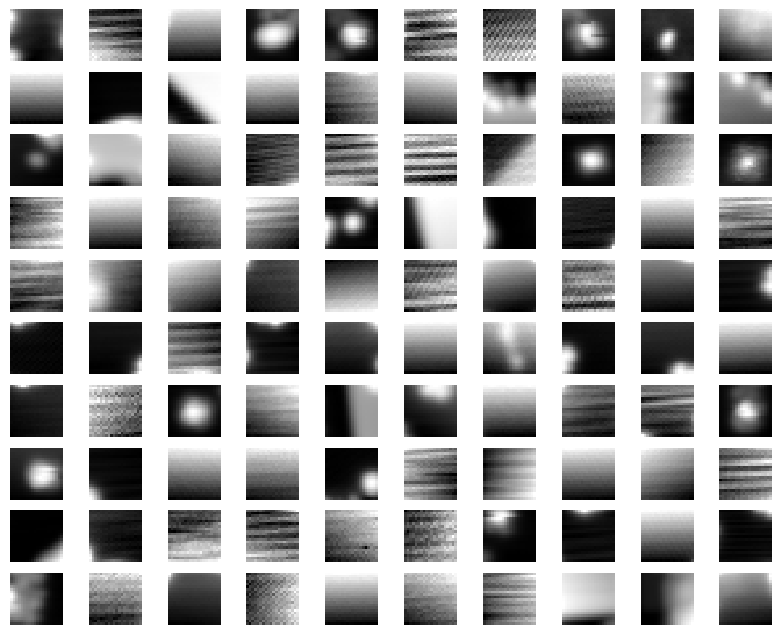

In [36]:
# plot  positive examples
fig, ax = plt.subplots(10, 10)
for ii in range(100):
    ax[ii // 10, ii % 10].imshow(stmp_neg[ii])
    ax[ii // 10, ii % 10].axis("off")

In [46]:
feat = np.concatenate((stmp_neg, stmp_pos), axis=0)
targ = np.concatenate((np.zeros(stmp_neg.shape[0]),
                                 np.ones(stmp_pos.shape[0])))

In [47]:
feat.shape

(874, 20, 20)

In [48]:
targ.shape

(874,)

In [50]:
feat_tr, feat_te, targ_tr, targ_te = train_test_split(feat, targ,
                                                      random_state=302, shuffle=True)
feat_tr.shape

(655, 20, 20)

In [52]:
feat_tr = np.expand_dims(feat_tr, axis=3)
feat_te = np.expand_dims(feat_te, axis=3)
feat_tr.shape

(655, 20, 20, 1)

Creiamo una NN
- conv2d 16 neurons
- maxpool2d 2x2
- conv2d 32 neurons
- maxpol2d 2x2
- flatten
- dense 64 neurons
- dense 2 neurons

In [54]:
layer1 = keras.layers.Conv2D(16, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             input_shape=(2 * wid, 2 * wid, 1),
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer2 = keras.layers.MaxPool2D(2)

layer3 = keras.layers.Conv2D(32, kernel_size=(5, 5), padding="same", 
                             activation="relu", 
                             kernel_regularizer=keras.regularizers.l2(0.001))

layer4 = keras.layers.MaxPool2D(2)

layer5 = keras.layers.Flatten()

layer6 = keras.layers.Dense(64, activation="relu",
                            kernel_regularizer=keras.regularizers.l2(0.001))

layer7 = keras.layers.Dense(2, activation="softmax")


layers = [layer1, layer2, layer3, layer4, layer5, layer6, layer7]
model = keras.Sequential(layers)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 20, 20, 16)        416       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        12832     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 64)               

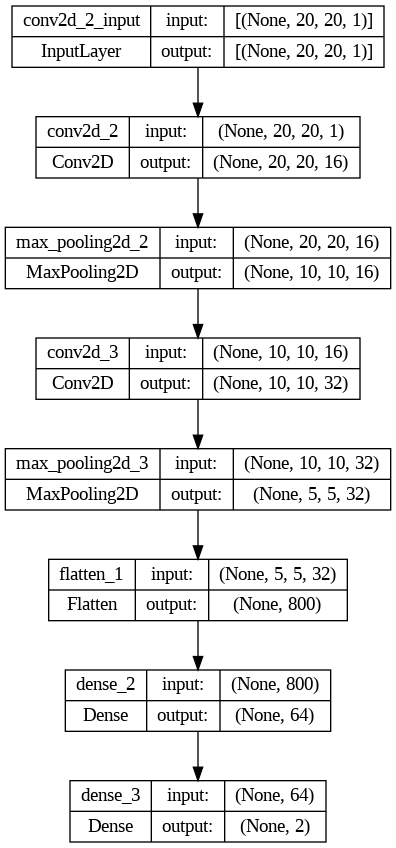

In [55]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [57]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics="accuracy")

In [59]:
history = model.fit(feat_tr, targ_tr, epochs=50, batch_size=50,
                    validation_split=0.1)

Epoch 1/50
12/12 [==============================] - 13s 54ms/step - loss: 0.7716 - accuracy: 0.7487 - val_loss: 0.6570 - val_accuracy: 0.9091
Epoch 2/50
12/12 [==============================] - 0s 11ms/step - loss: 0.5299 - accuracy: 0.9117 - val_loss: 0.3786 - val_accuracy: 0.8636
Epoch 3/50
12/12 [==============================] - 0s 11ms/step - loss: 0.3714 - accuracy: 0.8947 - val_loss: 0.3467 - val_accuracy: 0.9091
Epoch 4/50
12/12 [==============================] - 0s 11ms/step - loss: 0.3012 - accuracy: 0.9151 - val_loss: 0.2511 - val_accuracy: 0.9242
Epoch 5/50
12/12 [==============================] - 0s 12ms/step - loss: 0.2847 - accuracy: 0.9338 - val_loss: 0.2975 - val_accuracy: 0.9242
Epoch 6/50
12/12 [==============================] - 0s 10ms/step - loss: 0.2487 - accuracy: 0.9372 - val_loss: 0.2392 - val_accuracy: 0.9091
Epoch 7/50
12/12 [==============================] - 0s 12ms/step - loss: 0.2188 - accuracy: 0.9508 - val_loss: 0.2128 - val_accuracy: 0.9394
Epoch 8/50
1

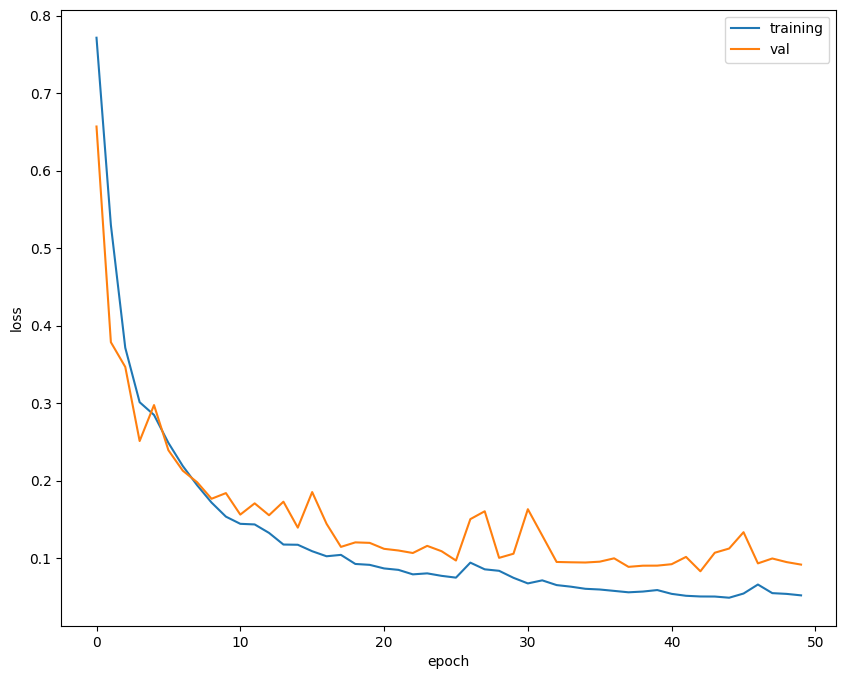

In [61]:
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

Vediamo che è presente del rumore che si manifesta come sbalzi. Di solito si può provare a diminuire sbalzi diminuendo il learning rate.

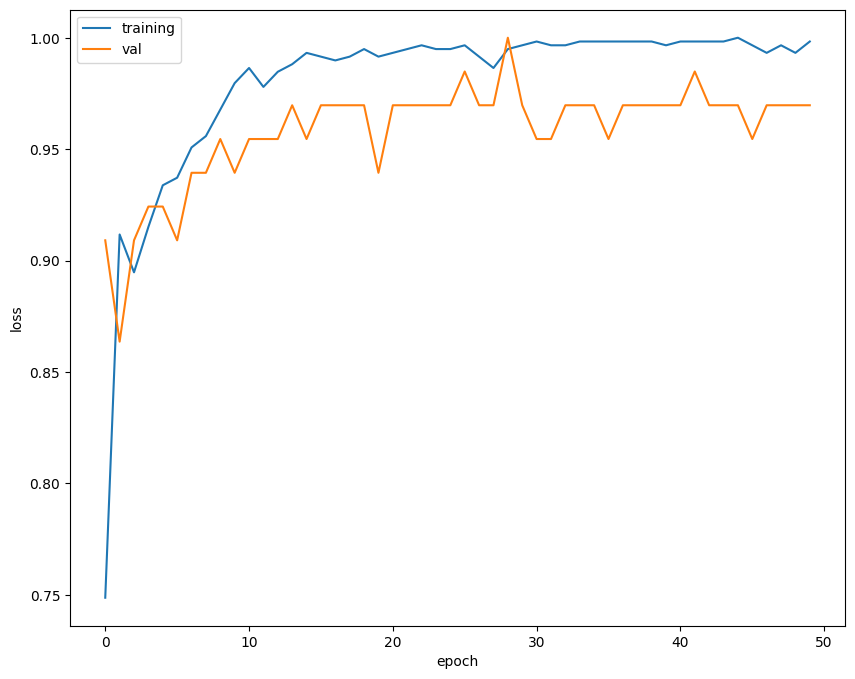

In [62]:
plt.plot(history.history["accuracy"], label="training")
plt.plot(history.history["val_accuracy"], label="val")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [64]:
loss_tr, acc_tr = model.evaluate(feat_tr, targ_tr)
loss_te, acc_te = model.evaluate(feat_te, targ_te)
print("{:.2f}, {:.2f}, {:.2f}, {:.2f},".format(
    loss_tr, acc_tr, loss_te, acc_te))

7/7 [==============================] - 0s 3ms/step - loss: 0.0867 - accuracy: 0.9909
0.05, 1.00, 0.09, 0.99,
